# Setup

In [4]:
# BiocManager::install(c('BiocGenerics', 'DelayedArray', 'DelayedMatrixStats',
#                        'limma', 'S4Vectors', 'SingleCellExperiment',
#                        'SummarizedExperiment', 'batchelor'))
# devtools::install_github('cole-trapnell-lab/leidenbase')
# devtools::install_github('cole-trapnell-lab/monocle3')
# install.packages("tidyverse")
# install.packages('Seurat')
# install.packages("cowplot")

In [1]:
suppressMessages({
    library(monocle3)
    library(Seurat)
    library(tidyverse)
    library(cowplot)
    dotenv::load_dot_env()
})

# Make Merged Mphage

In [2]:
PDIR = Sys.getenv("PROJECT_DIR")

In [3]:
fgid_meta = read.table(Sys.getenv("FG13metafile"), header=1) %>% 
    column_to_rownames("CellID")
cd14_meta = read.table(Sys.getenv("CD14metafile"), header=1) %>% 
    column_to_rownames("CellID")

In [4]:
FG13mloid = readRDS(file.path(PDIR,"FG13/celltype_objs/mloid_srobj.rds"))
CD14mloid = readRDS(file.path(PDIR,"CD14/celltype_objs/mloid_srobj.rds"))

FG13mloid@meta.data = fgid_meta[colnames(FG13mloid), ]
CD14mloid@meta.data = cd14_meta[colnames(CD14mloid), ]

In [5]:
Idents(CD14mloid) = "CD"
Idents(FG13mloid) = "FG"
mloid = merge(CD14mloid, FG13mloid)

In [6]:
mloid

An object of class Seurat 
41184 features across 21791 samples within 2 assays 
Active assay: SCT (17439 features, 0 variable features)
 1 other assay present: RNA

In [7]:
mloid = suppressWarnings({SCTransform(mloid, verbose=FALSE)})
mloid = RunPCA(mloid)
mloid = FindNeighbors(mloid, k.param = ceiling(0.5*sqrt(ncol(mloid))))
mloid = FindClusters(mloid)

PC_ 1 
Positive:  LTB, ACTB, IDO1, LSP1, CXCR4, PLAC8, RPS12, RPS23, LGALS2, MARCKSL1 
	   COTL1, RPS3A, GZMB, CD52, ACTG1, CCR7, FCER1A, CD1C, RGCC, CD1E 
	   TMSB10, PPA1, RPS27, RPL41, RPL31, SNX3, TXN, EEF1A1, RPS29, CST7 
Negative:  CCL3, CCL4, CCL3L3, CCL4L2, CXCL3, SEPP1, CXCL8, CXCL2, APOE, C1QA 
	   C1QB, CXCL1, IL1B, C1QC, NFKBIA, TNF, SLC40A1, IER3, FOLR2, HES1 
	   APOC1, LGMN, CTSC, CCL20, ADAMDEC1, EGR1, TNFAIP3, CTSD, CD14, CCL18 
PC_ 2 
Positive:  APOE, PTGDS, APOC1, MMP9, CCL18, GPNMB, MMP12, CTSD, PLA2G2D, FUCA1 
	   C1QB, CAPG, SEPP1, C1QA, ADAMDEC1, ACP5, CTSL, ATOX1, NUPR1, RARRES1 
	   CTSC, SERPINF1, PLA2G7, CYP27A1, LYZ, PSAP, PRDX1, LILRB4, PLD3, CXCL9 
Negative:  CCL3, CCL4, CCL3L3, CXCL8, CCL4L2, CXCL3, S100A9, S100A8, IL1B, CXCL2 
	   S100A4, NFKBIA, TNF, FCN1, BCL2A1, G0S2, HSPA1A, S100A6, HSPA1B, DUSP2 
	   CCL20, PLAC8, PPP1R15A, ZFP36, PLAUR, VCAN, IER3, TNFAIP3, TIMP1, S100A12 
PC_ 3 
Positive:  S100A9, S100A8, CXCL10, S100A4, FCN1, RP11-1143G9.4, LYZ, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 21791
Number of edges: 2538446

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8422
Number of communities: 16
Elapsed time: 14 seconds


In [8]:
mloid <- RunTSNE(mloid, 
                 initialization = FG13mloid@reductions$pca@cell.embeddings[, 1:2],
                 perplexity_list = c(30, ncol(mloid)/100),
                 learning_rate = ncol(mloid)/12,
                 exaggeration = 12,
                 dims = 1:22, 
                 fast_tsne_path = file.path(PDIR,"bin/fast_tsne"),
                 tsne.method = "FIt-SNE")

In [11]:
saveRDS(mloid, file.path(PDIR, "MloidDeepDive/mloid_merged_srobj.rds"))

In [ ]:
mloid = readRDS(file.path(PDIR, "MloidDeepDive/mloid_merged_srobj.rds"))

In [ ]:
mloid

In [ ]:
options(repr.plot.height = 8, repr.plot.width=8)
gridExtra::grid.arrange(DimPlot(mloid, group.by="patient"),
                  DimPlot(mloid, group.by="disease"),
                  DimPlot(mloid, group.by="is_doublet"),
                  DimPlot(mloid, group.by="seurat_clusters"),
                  ncol=2)

In [ ]:
unique(mloid$curatedname[!grepl("Doub|LowQual", mloid$type)])

In [ ]:
unique(mloid$type)

In [ ]:
plottypes = unique(mloid$curatedname[!grepl("Doub|LowQual", mloid$type)])
plottypes = c("CD.Mac.CXCL2.TNF", "FG.Mac.MKI67.LYZ", "FG.Mac.APOE.PTGDS", "CD.Mac.APOE.PTGDS")

In [ ]:
plist = list()
for (tnn in c("CD.Mono/Mac.CXCL10.CXCL11", "FG.Mac.MKI67.LYZ",
              "FG.Mac.APOE.PTGDS", "CD.Mac.APOE.PTGDS",
              "CD.cDC2.CLEC10A.CD1E")) {
    Idents(mloid) = mloid$curatedname == tnn
    plist[[tnn]] = DimPlot(mloid, reduction = "tsne", cols=c("gray", "red"), pt.size = 0.01) + 
        ggtitle(tnn) +
        theme_void() +
        theme(axis.title = element_text(size=2)) +
        NoLegend()
}

In [ ]:
options(repr.plot.height = 8, repr.plot.width=8)
gridExtra::grid.arrange(grobs = plist,
                        ncol=ceiling(sqrt(length(plottypes))))

# Filter

In [140]:
mloid = readRDS(file.path(PDIR, "MloidDeepDive/mloid_merged_srobj.rds"))

In [142]:
srobj = mloid[, !grepl("Doub|LowQual", mloid$type)]

In [143]:
# keep mphages & mono
srobj = srobj[, !grepl("DC", srobj$curatedname)]

In [145]:
pltdat = srobj@meta.data %>%
    group_by(curatedname) %>%
    summarize(patsplit = length(unique(patient)),
              patginismp = 1 - sum(((table(patient)) / (length(patient)))^2),
              disease = first(disease))

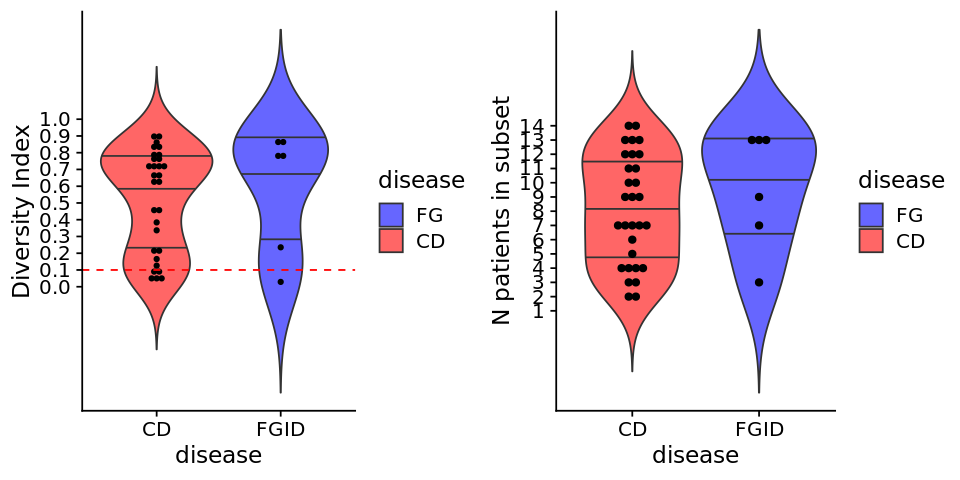

In [146]:
# patient specific?
p1 = ggplot(pltdat) +
    geom_violin(aes(y=patginismp, x=disease, fill=disease),
                trim = FALSE,
                draw_quantiles = c(0.25, 0.5, 0.75), 
                alpha=0.6) +
    geom_dotplot(aes(y=patginismp, x=disease),
                 binaxis = "y",
                 stackdir = "center",
                 binwidth=.03) +
    geom_hline(aes(yintercept=0.1), color='red', linetype=2) +
    scale_y_continuous(breaks=seq(0, 1, 0.1)) +
    ylab("Diversity Index") +
    scale_fill_manual(limits=c("FGID", "CD"),
                        labels=c("FG", "CD"),
                        values=c("#0000ff", "#ff0000")) +
    theme_cowplot()
p2 = ggplot(pltdat) +
    geom_violin(aes(y=patsplit, x=disease, fill=disease),
                trim = FALSE,
                draw_quantiles = c(0.25, 0.5, 0.75), 
                alpha=0.6) +
    geom_dotplot(aes(y=patsplit, x=disease),
                 binaxis = "y",
                 stackdir = "center",
                 binwidth=.5) +
    scale_y_continuous(breaks=1:14) +
    ylab("N patients in subset") +
    scale_fill_manual(limits=c("FGID", "CD"),
                        labels=c("FG", "CD"),
                        values=c("#0000ff", "#ff0000")) +
    theme_cowplot()
options(repr.plot.height = 4, repr.plot.width=8)
gridExtra::grid.arrange(grobs = list(p1, p2),
                        ncol=ceiling(sqrt(2)))

In [147]:
summary(pltdat$patginismp[pltdat$patsplit < 3])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03920 0.04454 0.04987 0.04987 0.05521 0.06055 

In [148]:
summary(pltdat$patsplit[pltdat$patginismp < 0.1])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     2.0     3.0     2.8     3.0     4.0 

In [149]:
pat_specific_clst = pltdat[pltdat$patginismp < 0.1,]

In [150]:
pat_specific_clst

curatedname,patsplit,patginismp,disease
<chr>,<int>,<dbl>,<chr>
CD.Mac.CXCL2.TNF,2,0.03920000,CD
CD.Mac.LYZ.TXN,3,0.04967153,CD
CD.Mono.FCN1.HSPA1A,4,0.07780000,CD
CD.Mono/Mac.CCL4.DDX3Y,2,0.06054688,CD
FG.Mac.CXCL3.CXCL8,3,0.02886556,FGID


In [151]:
srobj = srobj[, !(srobj$curatedname %in% pat_specific_clst)]

In [152]:
srobj

An object of class Seurat 
41715 features across 10134 samples within 2 assays 
Active assay: SCT (17970 features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, tsne

In [153]:
# options(repr.plot.height = 10, repr.plot.width=10)
# gridExtra::grid.arrange(DimPlot(srobj, group.by="patient") + NoLegend(),
#                   DimPlot(srobj, group.by="disease"),
#                   DimPlot(srobj, group.by="curatedname") + NoLegend(),
#                   DimPlot(srobj, group.by="seurat_clusters"),
#                   ncol=2)

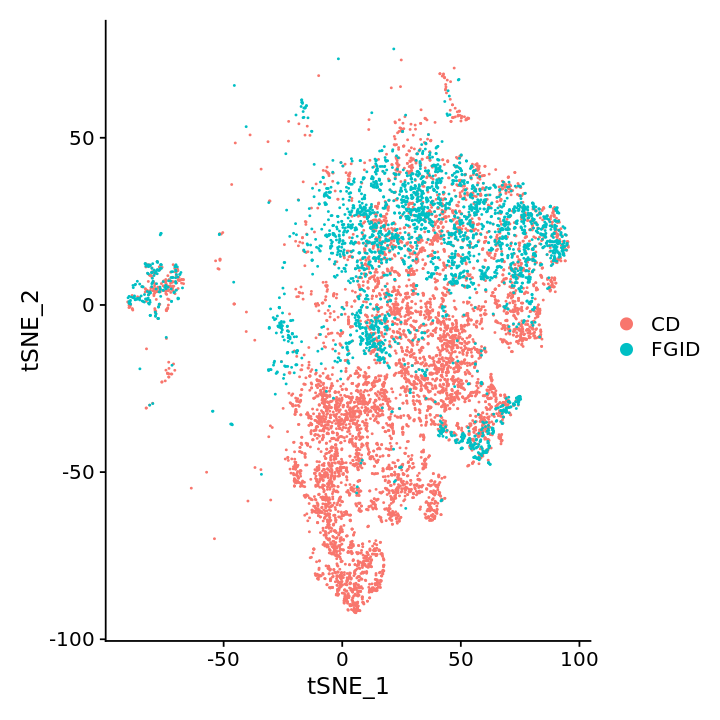

In [154]:
options(repr.plot.height = 6, repr.plot.width=6)
DimPlot(srobj, group.by="disease")

In [155]:
# options(repr.plot.height = 10, repr.plot.width=15)
# FeaturePlot(tclls, c("MMP9","APOE","SEPP1", "CD63", 
#                    "CXCL9","CXCL10","S100A4", "AXL", 
#                    "STAT1","TNF", "CCL3", "CCL4"))

In [156]:
saveRDS(srobj, file.path(PDIR, "MloidDeepDive/mloid_filtered_srobj.rds"))

In [157]:
srobj = readRDS(file.path(PDIR, "MloidDeepDive/mloid_filtered_srobj.rds"))

In [158]:
srobj

An object of class Seurat 
41715 features across 10134 samples within 2 assays 
Active assay: SCT (17970 features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, tsne

# Calculate Genes

In [159]:
FG13 = readRDS(Sys.getenv("FG13srobj"))
CD14 = readRDS(Sys.getenv("CD14srobj"))

In [160]:
FG13@meta.data = fgid_meta[colnames(FG13), ]

In [161]:
CD14@meta.data = cd14_meta[colnames(CD14), ]

In [162]:
# find markers for mloid against other cell types
Idents(FG13) = colnames(FG13) %in% colnames(srobj[, srobj$disease == "FGID"])
fgid_markers = FindMarkers(FG13[, !grepl("Doub|LowQual", FG13$type)  & 
                                  !(FG13$curatedname %in% pat_specific_clst)],
                           assay="RNA",
                           ident.1=TRUE, ident.2=FALSE,
                           only.pos=TRUE, test.use="wilcox",
                           max.cells.per.ident=10000)
fgid_markers %>% dim

Idents(CD14) = colnames(CD14) %in% colnames(srobj[, srobj$disease == "CD"])
cd14_markers = FindMarkers(CD14[, !grepl("Doub|LowQual", CD14$type) & 
                                 !(CD14$curatedname %in% pat_specific_clst)],
                           assay="RNA",
                           ident.1=TRUE, ident.2=FALSE,
                           only.pos=TRUE, test.use="wilcox",
                           max.cells.per.ident=10000)
cd14_markers %>% dim

[1] 701   5

[1] 796   5

In [163]:
# find disease 
Idents(srobj) = srobj$disease
disease.markers = FindMarkers(srobj, assay="RNA",
               ident.1="CD", ident.2="FGID",
               only.pos=FALSE, test.use="wilcox",
               max.cells.per.ident=10000)

In [164]:
nrow(disease.markers)

[1] 297

In [165]:
psuedotime_genes = unique(rownames(fgid_markers), rownames(cd14_markers)) %>%
    .[!(. %in% rownames(disease.markers))]

In [166]:
srobj@misc$pseudotime_genes = psuedotime_genes

In [168]:
srobj@misc$pseudotime_genes %>% length

[1] 539

In [169]:
saveRDS(srobj, file.path(PDIR, "MloidDeepDive/mloid_filtered_calcGenes_srobj.rds"))

# Get umap

In [170]:
srobj = readRDS(file.path(PDIR, "MloidDeepDive/mloid_filtered_calcGenes_srobj.rds"))

In [171]:
srobj = ScaleData(srobj, assay = "RNA", features=srobj@misc$pseudotime_genes)
srobj = RunPCA(srobj, assay="RNA", 
       features=srobj@misc$pseudotime_genes,
       reduction.name="pca_coregenes", reduction.key = "PCcore_")

Centering and scaling data matrix

PCcore_ 1 
Positive:  TMSB4X, ACTB, CCL18, FTL, PELI1, CD93, IFI44L, C9orf72, CSTA, NLRP3 
	   FES, ATG4C, HMOX1, CDC42EP2, ETS2, GFRA2, RGS18, NQO2, C10orf11, IER5 
	   SHTN1, WWP1, MMP12, AP2A2, LAG3, KLF10, SIGLEC1, RALB, TFPT, FGD2 
Negative:  GRN, HLA-E, CTSB, PSAP, HLA-DMB, FGL2, CTSZ, CD63, SRGN, CD83 
	   NR4A2, IFI30, CHMP1B, ZNF331, TMEM176B, HLA-DRB1, ITGB2, PNRC1, HSP90B1, CYBA 
	   CTSC, TMBIM6, DUSP1, LITAF, PLD3, HLA-DQA1, SGK1, TMEM176A, TPP1, CTSH 
PCcore_ 2 
Positive:  IL1B, BCL2A1, NFKBIA, FOSB, TNFAIP3, DUSP1, NFKBIZ, ZFP36, IER3, PTGS2 
	   HSPA1A, HSPA1B, MCL1, CD83, TNF, ARL5B, PNRC1, NLRP3, SRGN, KDM6B 
	   NR4A2, STX11, SKIL, SOCS3, ATF3, PRDM1, PFKFB3, ATP2B1, KLF4, TNFAIP2 
Negative:  FUCA1, CAPG, CTSD, GPNMB, FTL, MMP9, MMP12, ATOX1, C1QB, C1QA 
	   IL18, PLD3, CCL18, LILRB4, CD68, TMEM176B, ENPP2, CTSH, CTSC, TSPAN4 
	   CD63, LGALS3, NR1H3, CSTB, TMSB4X, LIPA, TMEM176A, AKR1B1, CTSA, CD59 
PCcore_ 3 
Positive:  ACTB, COTL

In [215]:
srobj = RunUMAP(srobj, assay="RNA", 
        reduction="pca_coregenes", dims=1:50,
        n.neighbors=54, min.dist=0.1, #ceiling(0.5*sqrt(ncol(srobj))),
        verbose=FALSE)

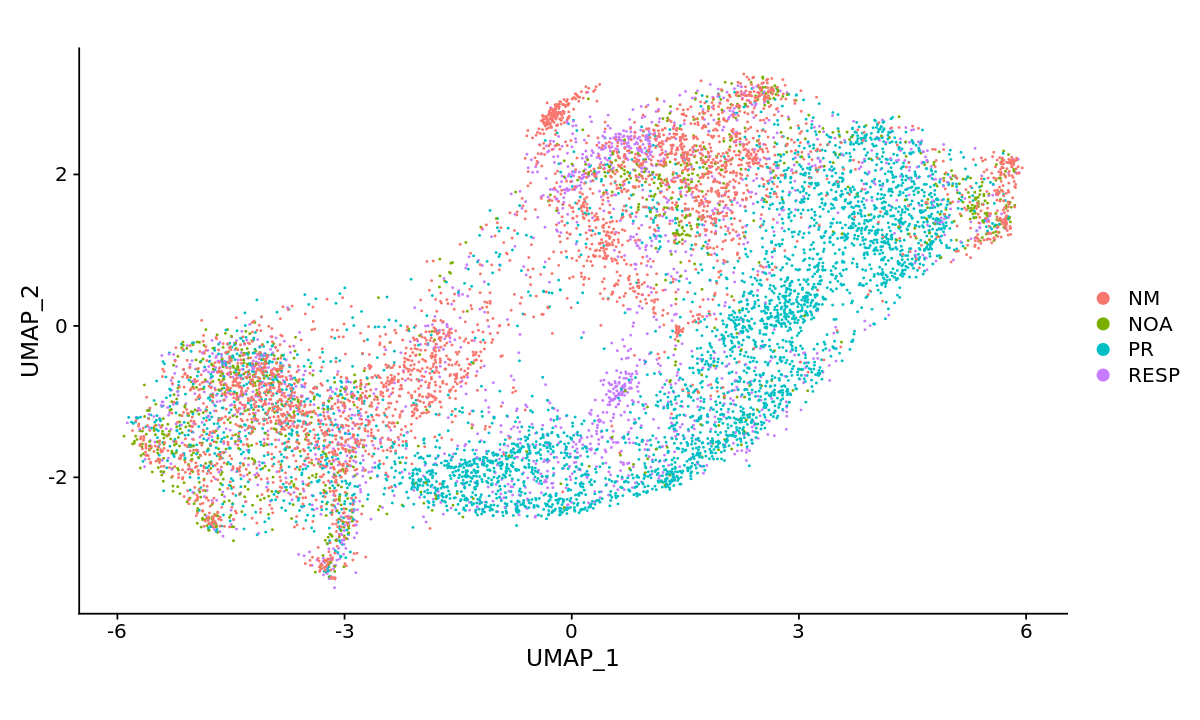

In [3]:
options(repr.plot.height=6, repr.plot.width=10)
DimPlot(srobj, reduction="umap", label = FALSE,group.by="antiTNF_response")+
#     NoLegend()+
    coord_fixed()

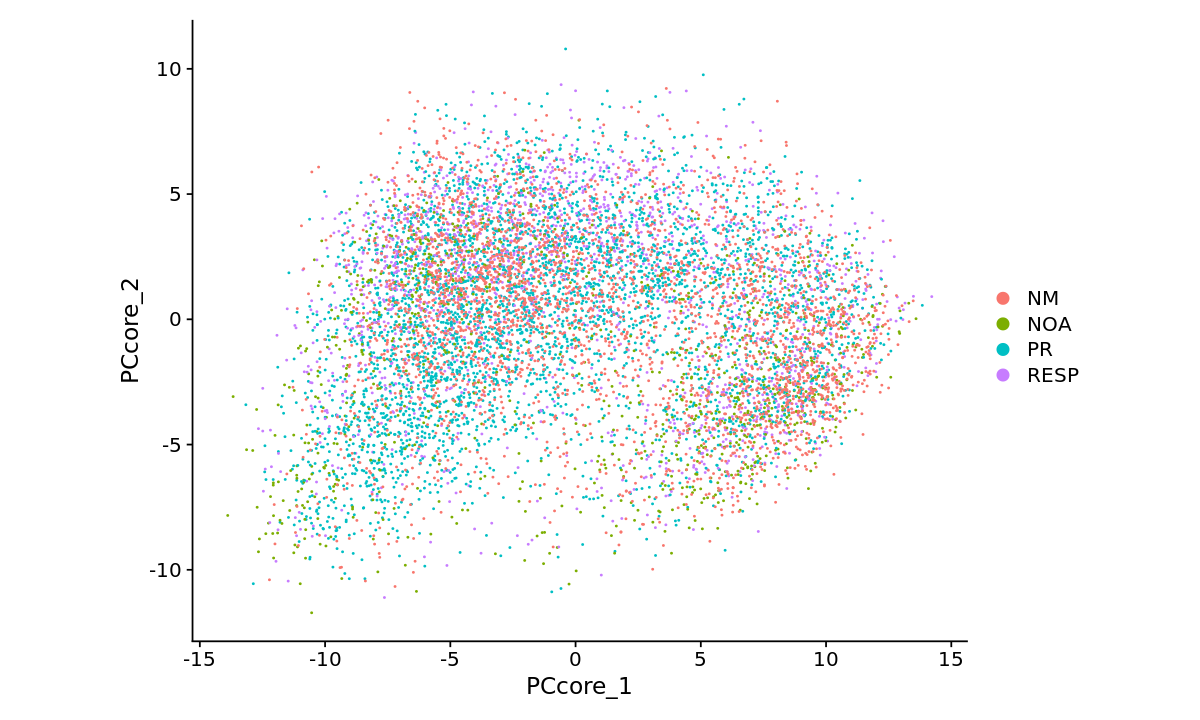

In [5]:
DimPlot(srobj, reduction="pca_coregenes", label = FALSE,group.by="antiTNF_response")+
#     NoLegend()+
    coord_fixed()

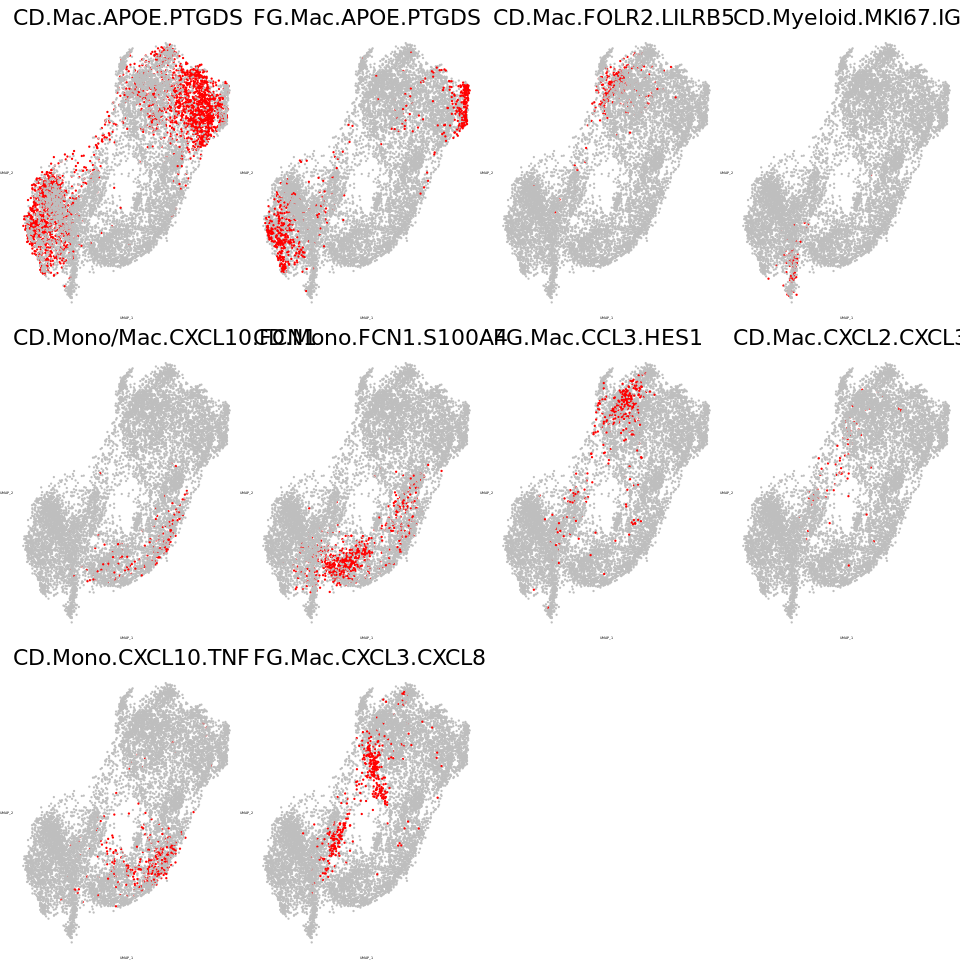

In [217]:
plottypes = c("CD.Mac.APOE.PTGDS", "FG.Mac.APOE.PTGDS",
              "CD.Mac.FOLR2.LILRB5", "CD.Myeloid.MKI67.IGKC",
              "CD.Mono/Mac.CXCL10.FCN1", "CD.Mono.FCN1.S100A4",
              'FG.Mac.CCL3.HES1', 'CD.Mac.CXCL2.CXCL3',
              'CD.Mono.CXCL10.TNF','FG.Mac.CXCL3.CXCL8' 
              )
plist = list()
for (tnn in plottypes) {
    Idents(srobj) = srobj$curatedname == tnn
    plist[[tnn]] = DimPlot(srobj, reduction = "umap", cols=c("gray", "red"), pt.size = 0.01) + 
        ggtitle(tnn) +
        theme_void() +
        theme(axis.title = element_text(size=2)) +
        NoLegend()
}

options(repr.plot.height = 8, repr.plot.width=8)
gridExtra::grid.arrange(grobs = plist,
                        ncol=ceiling(sqrt(length(plottypes))))

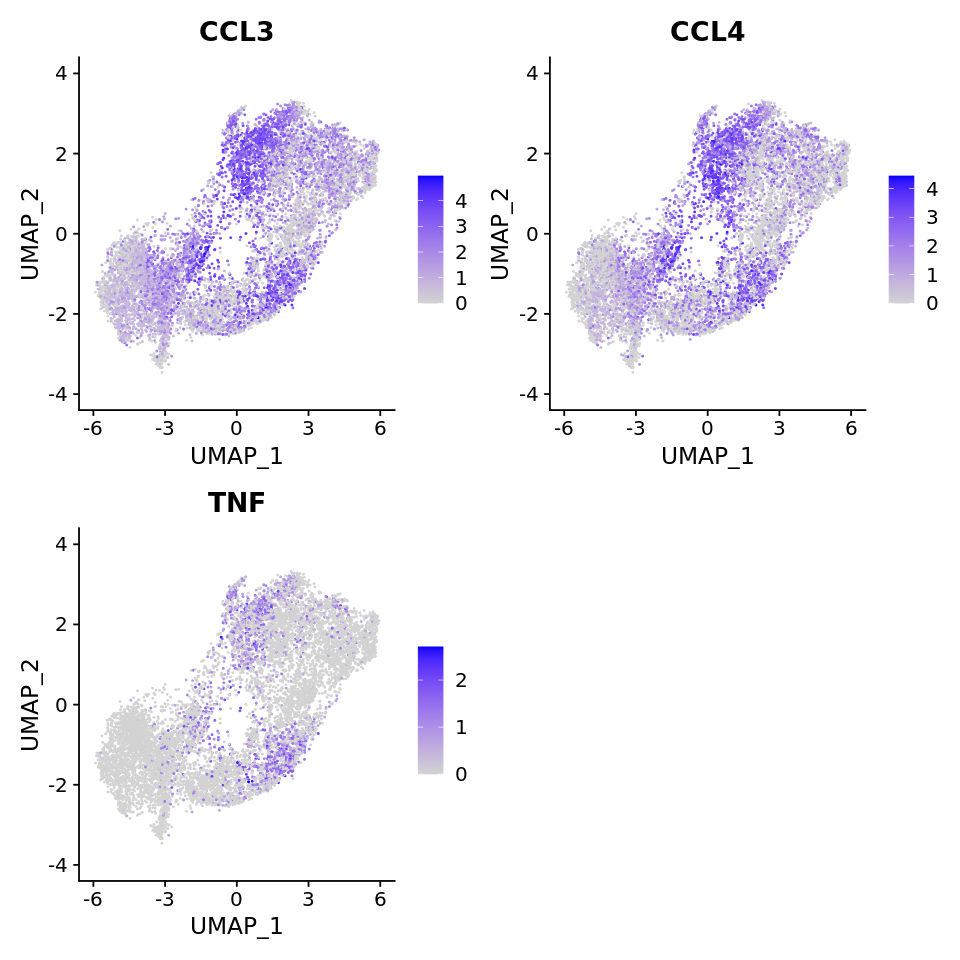

In [218]:
FeaturePlot(srobj, c("CCL3", "CCL4", "TNF"), reduction="umap")

In [174]:
table(srobj$antiTNF_response)


  NM  NOA   PR RESP 
3129 1072 4016 1917 

In [219]:
srobj$umapX = srobj@reductions$umap@cell.embeddings[,"UMAP_1"]
srobj$umapY = srobj@reductions$umap@cell.embeddings[,"UMAP_2"]

In [8]:
srobj$pc1 = srobj@reductions$pca_coregenes@cell.embeddings[,"PCcore_1"]
srobj$pc2 = srobj@reductions$pca_coregenes@cell.embeddings[,"PCcore_2"]

# Make monocle object

In [3]:
srobj = readRDS(file.path(PDIR, "MloidDeepDive/mloid_filtered_calcGenes_srobj.rds"))

In [4]:
# tclls = srobj[, srobj$is_mphage] # & !srobj$is_mphage_chemo]

srobj@assays$SCT@meta.features$gene_short_name = rownames(srobj@assays$SCT@meta.features)
srobj@assays$RNA@meta.features$gene_short_name = rownames(srobj@assays$RNA@meta.features)
srobj@assays$RNA@counts %>% colnames %>% length
srobj@meta.data %>% rownames %>% head

cds <- new_cell_data_set(srobj@assays$RNA@counts,
                         cell_metadata = srobj@meta.data,
                         gene_metadata = srobj@assays$RNA@meta.features)

[1] 10134

[1] "p011_T0D_ILE_LPS_3p_AAAGCAATCTATCCCG-1"
[2] "p011_T0D_ILE_LPS_3p_AAATGCCGTACAAGTA-1"
[3] "p011_T0D_ILE_LPS_3p_AACCATGAGGTGTTAA-1"
[4] "p011_T0D_ILE_LPS_3p_AACCATGGTTCCAACA-1"
[5] "p011_T0D_ILE_LPS_3p_AACGTTGAGCTCAACT-1"
[6] "p011_T0D_ILE_LPS_3p_AACGTTGCAATCCAAC-1"

In [5]:
table(srobj$disease)


  CD FGID 
7005 3129 

In [6]:
cds

class: cell_data_set 
dim: 23745 10134 
metadata(1): cds_version
assays(1): counts
rownames(23745): RP11-34P13.7 FO538757.2 ... RP4-539M6.14 RP4-569D19.8
rowData names(1): gene_short_name
colnames(10134): p011_T0D_ILE_LPS_3p_AAAGCAATCTATCCCG-1
  p011_T0D_ILE_LPS_3p_AAATGCCGTACAAGTA-1 ...
  p050_T0D_ILE_LPS_3p_TTTGTCAAGTGTACGG-1
  p050_T0D_ILE_LPS_3p_TTTGTCACACAGACAG-1
colData names(37): cluster orig_idx ... nFeature_RNA Size_Factor
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [7]:
cds <- preprocess_cds(cds, method="PCA", num_dim = 50, use_genes=srobj@misc$pseudotime_genes)
# cds <- preprocess_cds(cds, method="LSI", num_dim = 45, use_genes=markers_allmphage_againstall)
# cds <- align_cds(cds, preprocess_method = "LSI", alignment_group = "disease")

In [8]:
reducedDims(cds)

List of length 1
names(1): PCA

In [33]:
round(10^seq(-2, 0, 0.2),digits=2)

[1] 0.01 0.02 0.03 0.04 0.06 0.10 0.16 0.25 0.40 0.63 1.00

In [27]:
cds$antiTNF_response

[1] 10134

In [34]:
umapcoords = data.table::rbindlist(lapply(round(10^seq(-2, 0, 0.2),digits=2), 
                                          function(md) {
    cds <- reduce_dimension(cds, cores=10,
                        umap.n_neighbors = 54L, 
                        umap.min_dist = md,
                        preprocess_method="PCA", 
                        max_components=2)
    data.frame(
        cellID = colnames(cds),
        mindist=md,
        TNFR = cds$antiTNF_response,
        umapX = reducedDims(cds)[["UMAP"]][, 1],
        umapY = reducedDims(cds)[["UMAP"]][, 2]
        )
}))

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Note: reduce_dimension will

In [35]:
saveRDS(umapcoords, file.path(PDIR, "MloidDeepDive/umapcoords.rds"))

In [30]:
dim(umapcoords)

[1] 111474      5

In [32]:
tail(umapcoords)

mindist,cellID,TNFR,umapX,umapY
<int>,<fct>,<fct>,<dbl>,<dbl>
11,p050_T0D_ILE_LPS_3p_TTTCCTCTCACTATTC-1,NM,1.345684,1.850304
11,p050_T0D_ILE_LPS_3p_TTTCCTCTCCCTAACC-1,NM,0.375726,2.664457
11,p050_T0D_ILE_LPS_3p_TTTGGTTCATGATCCA-1,NM,-2.675387,-1.706318
11,p050_T0D_ILE_LPS_3p_TTTGGTTTCCTCCTAG-1,NM,-4.152969,-2.779067
11,p050_T0D_ILE_LPS_3p_TTTGTCAAGTGTACGG-1,NM,-1.846902,2.409233
11,p050_T0D_ILE_LPS_3p_TTTGTCACACAGACAG-1,NM,4.112446,2.811314


In [16]:
cds <- reduce_dimension(cds, cores=10,
                        umap.n_neighbors = 54L, 
                        umap.min_dist = 1,
                        preprocess_method="PCA", 
                        max_components=2)

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'



  |======================================================================| 100%


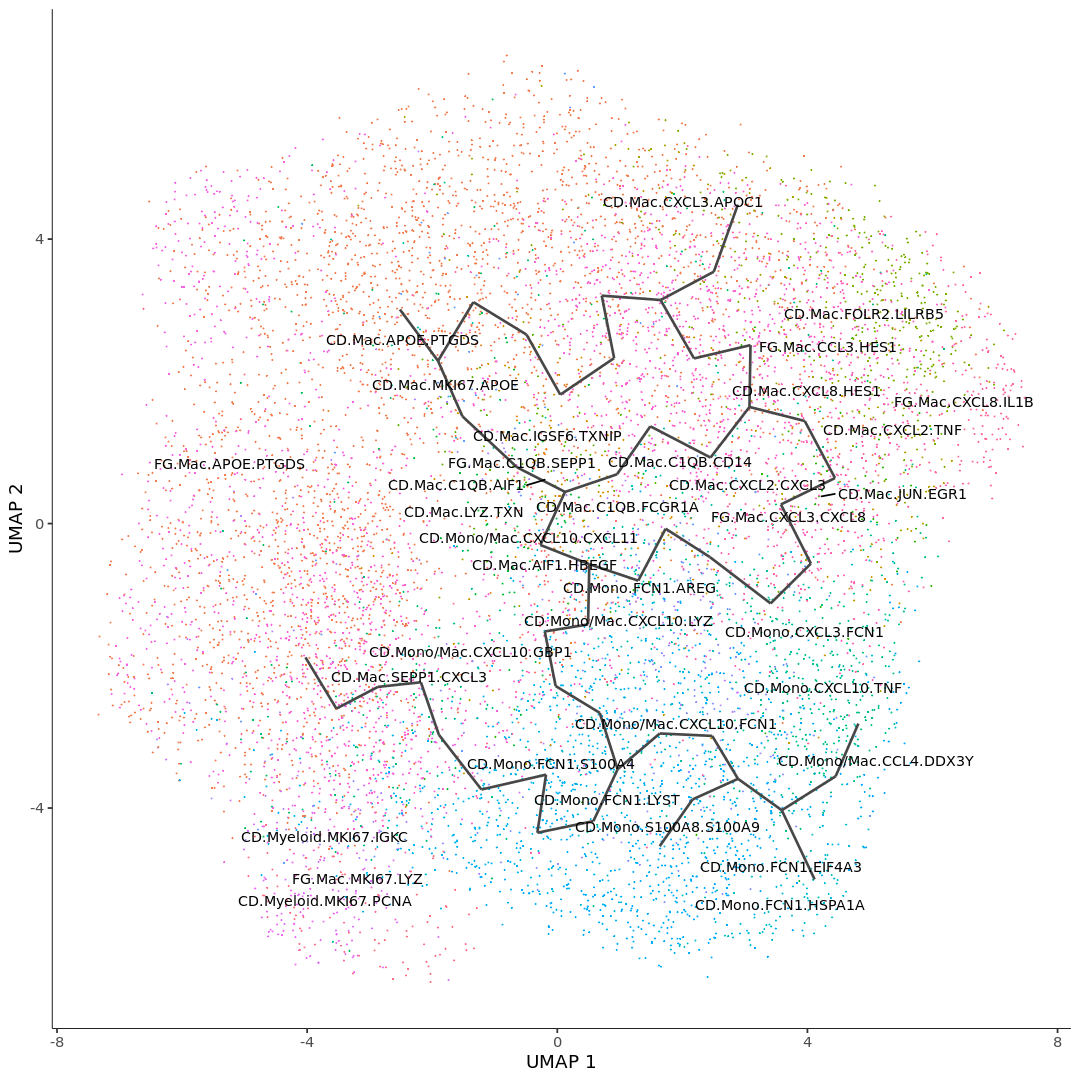

In [17]:
options(repr.plot.width=9, repr.plot.height=9)
cds <- cluster_cells(cds, cores=10)
cds <- learn_graph(cds, use_partition = FALSE, learn_graph_control = list(minimal_branch_len = 10))
plot_cells(cds, #reduction_method = "PCA",
           color_cells_by = "curatedname",
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           group_label_size=3,
           label_branch_points=FALSE)

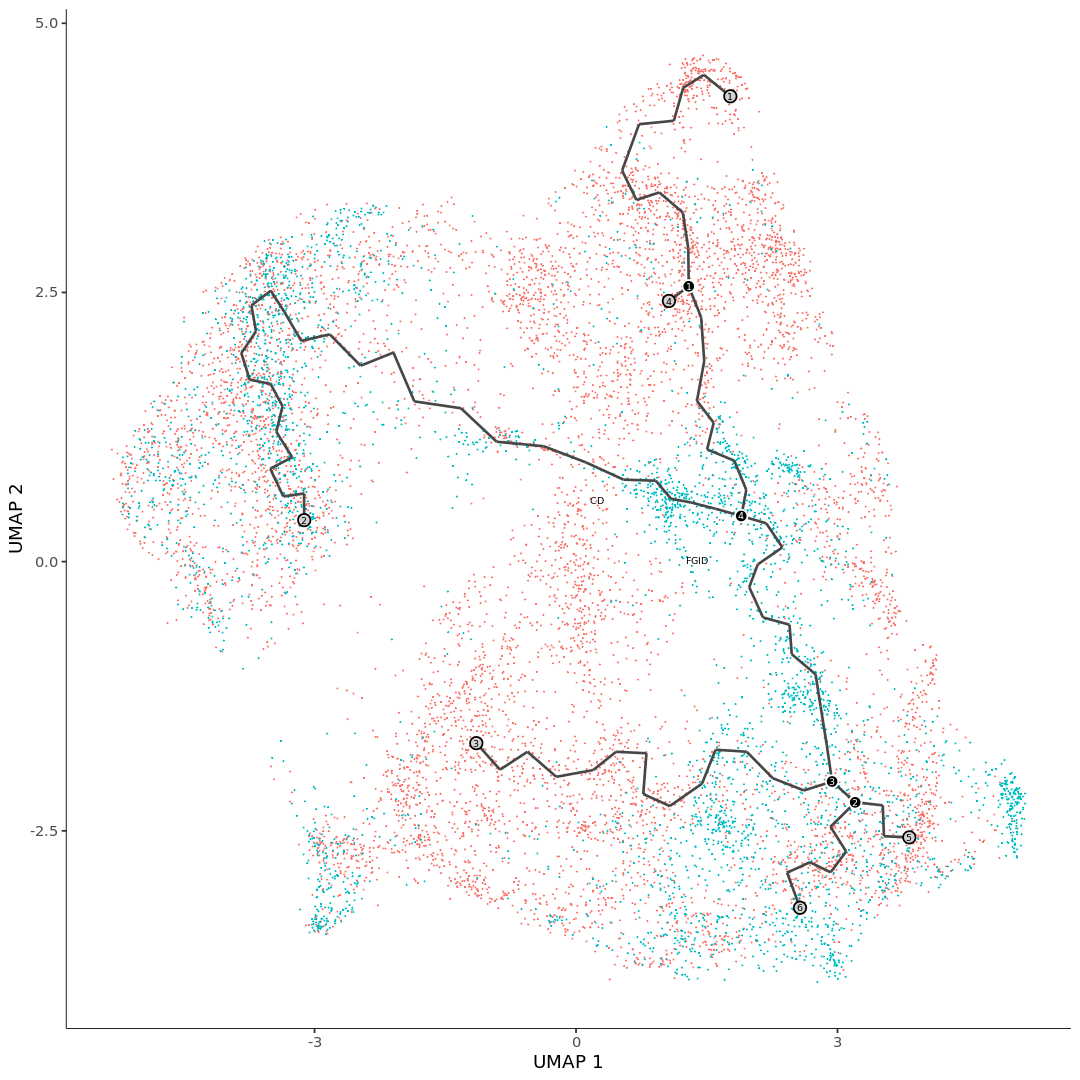

In [139]:
plot_cells(cds, 
           label_groups_by_cluster=FALSE,
           color_cells_by = "disease")

In [ ]:
options(repr.plot.height=15, repr.plot.width=15)
plot_cells(cds, #reduction_method = "PCA",
           genes=c("MMP9","APOE","SEPP1", "CD63", 
                   "CXCL9","CXCL10","S100A4", "AXL", 
                   "STAT1","TNF", "CCL3", "CCL4"),
           label_cell_groups=FALSE,
           show_trajectory_graph=FALSE) +
#     coord_fixed()
    coord_cartesian()

In [ ]:
srobj$umapX = reducedDims(cds)[["UMAP"]][, 1]
srobj$umapY = reducedDims(cds)[["UMAP"]][, 2]

# plot density

In [9]:
get_contour = function(df) {
    fhat = ks::kde(df[, c("x", "y")], compute.cont=TRUE)
    dimnames(fhat[['estimate']]) <- list(fhat[["eval.points"]][[1]],
                                         fhat[["eval.points"]][[2]])
    contours = reshape2::melt(fhat[["estimate"]])
    contours$quantile = fhat[["cont"]]["5%"]
    return(contours)
}

hpd_contour <- function (x, n = 50, prob = 0.95, ...) {
  post1 <- MASS::kde2d(x[[1]], x[[2]], n = n, ...)

  dx <- diff(post1$x[1:2])
  dy <- diff(post1$y[1:2])
  sz <- sort(post1$z)
  c1 <- cumsum(sz) * dx * dy

  levels <- sapply(prob, function(x) {
    approx(c1, sz, xout = 1 - x)$y
  })

  return(data.table::rbindlist(
      grDevices::contourLines(post1$x, post1$y, post1$z, levels = levels), idcol="sbgrp"))
}

# fhat = ks::kde(d[, c("x", "y")], compute.cont=TRUE)
# dimnames(fhat[['estimate']]) <- list(fhat[["eval.points"]][[1]], fhat[["eval.points"]][[2]])
# aa = reshape2::melt(fhat[["estimate"]])

In [10]:
hellinger2d = function(psmp, qsmp, bgridsize=rep(100, dim(qsmp)[2])) {
#     if (dim(psmp)[2] != dim(qsmp)[2]) {
#         error("dimensions must be equal!")
#     }
    psmp = as.matrix(psmp)
    qsmp = as.matrix(qsmp)
    smp = rbind(psmp, qsmp)
#     K = dim(psmp)[2]
    
    mins = colMins(smp)
    maxs = colMaxs(smp)
    H = ks::Hpi(smp)
    
    phat = ks::kde(psmp,
                   H=H, 
                   bgridsize=bgridsize, 
                   xmin=mins, xmax=maxs, 
                   compute.cont=FALSE,
                   approx.cont=FALSE)$estimate
    qhat = ks::kde(qsmp, 
                   H=H, 
                   bgridsize=bgridsize, 
                   xmin=mins, xmax=maxs, 
                   compute.cont=FALSE,
                   approx.cont=FALSE)$estimate
    
    ps = round(phat, digits=15)
    ps = ps / sum(ps) # make sum to 1
    
    qs = round(qhat, digits=15)
    qs = qs / sum(qs) # make sum to 1
    
    return(
        sqrt(1 - sum(sqrt(ps*qs)))
    )
}

In [511]:
# Start the clock!
ptm <- proc.time()
for (i in 1:10) {
hellinger2d(psmp, qsmp)
}
proc.time() - ptm

   user  system elapsed 
  8.116   0.004   8.122 

In [521]:
combn(c("NM", "NOA", "RESP", "PR"),2, simplify = FALSE)

[[1]]
[1] "NM"  "NOA"

[[2]]
[1] "NM"   "RESP"

[[3]]
[1] "NM" "PR"

[[4]]
[1] "NOA"  "RESP"

[[5]]
[1] "NOA" "PR" 

[[6]]
[1] "RESP" "PR"

In [110]:
test.dists = data.table::rbindlist(lapply(combn(c("NM", "NOA", "RESP", "PR"),2, simplify=FALSE), function(grp) {
    data.frame(grp1=grp[1],
               grp2=grp[2],
               dist=hellinger2d(
                    psmp=srobj@meta.data[srobj$antiTNF_response == grp[1], c("umapX", "umapY")],
                    qsmp=srobj@meta.data[srobj$antiTNF_response == grp[2], c("umapX", "umapY")]
               ))
}))

In [111]:
test.dists %>% arrange(dist)

grp1,grp2,dist
<fct>,<fct>,<dbl>
NM,NOA,0.3963051
NOA,RESP,0.4197339
NM,RESP,0.4499656
RESP,PR,0.4515140
NOA,PR,0.5359993
NM,PR,0.5536194


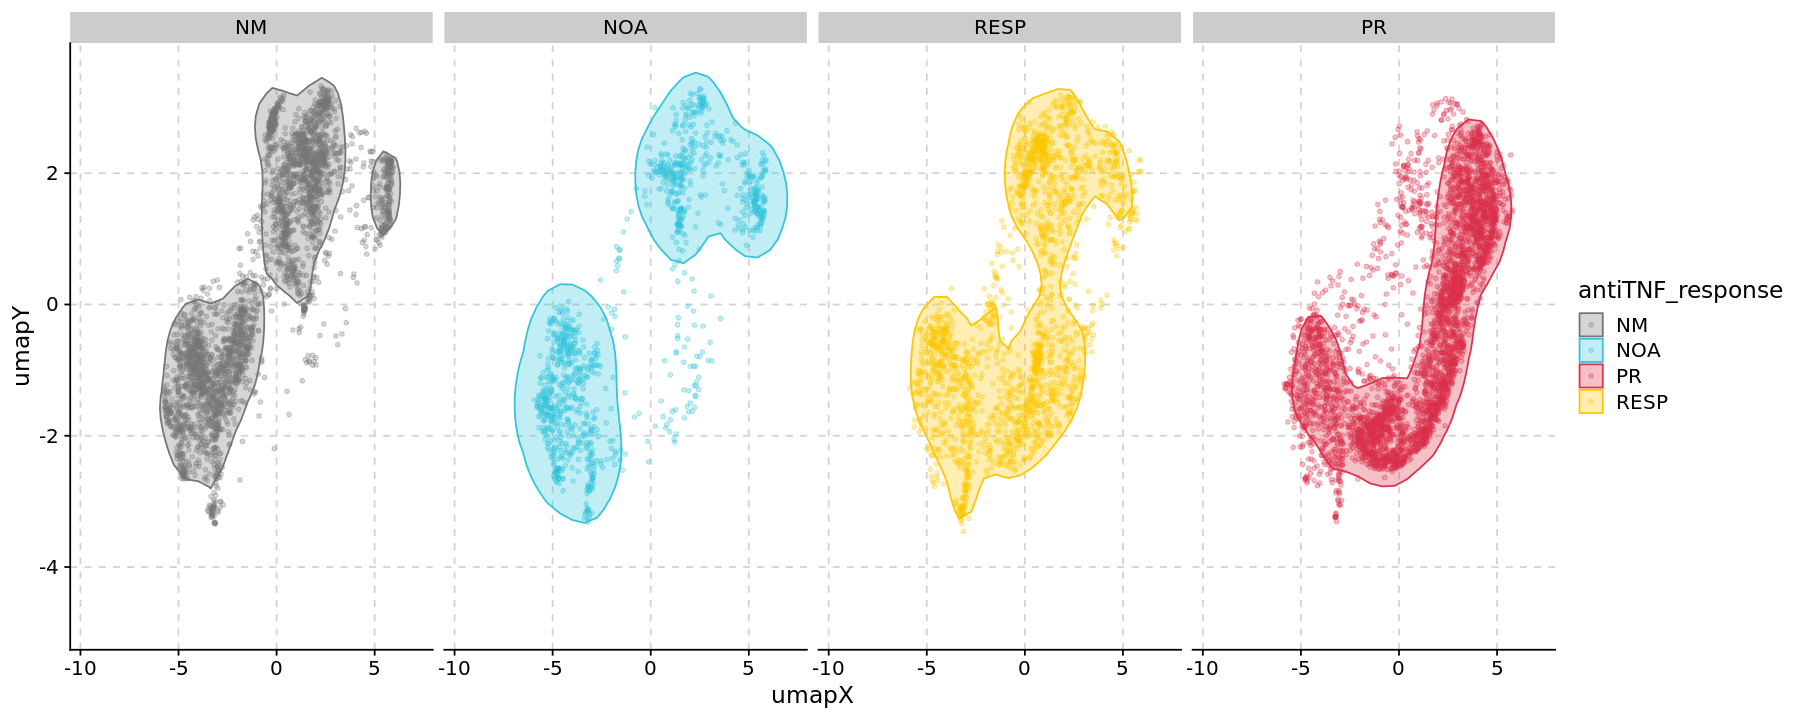

In [226]:
xnudge=2.8
ynudge=1.4

clines = data.frame(umapX=srobj$umapX,
                    umapY=srobj$umapY,
                    antiTNF_response=factor(srobj$antiTNF_response)) %>% 
  group_by(antiTNF_response) %>% 
  do(hpd_contour(.[, c("umapX", "umapY")], 
                 prob=0.8,
                 lims=c(c(range(min(srobj$umapX):max(srobj$umapX)))*xnudge,
                        c(range(min(srobj$umapY):max(srobj$umapY)))*ynudge)))

disease.severity.colors = c("NM"="#757575","NOA"="#32c4db","PR"="#db324c","RESP"="#fcc603")
options(repr.plot.width=15, repr.plot.height=6)

ggplot(srobj@meta.data, 
       aes(x=umapX, y=umapY, color=antiTNF_response)) + 
    cowplot::theme_cowplot() + 
    theme(panel.grid.major=element_line(linetype="dashed",color="lightgrey")) +
#     stat_density_2d(aes(fill=antiTNF_response), geom="polygon", alpha=.3, bins=10) +
    geom_polygon(data=clines, aes(x=x, y=y,subgroup=sbgrp,fill=antiTNF_response), alpha=.3) +
    geom_point(size=1, alpha=.3) +
    xlim(c(range(min(srobj$umapY):max(srobj$umapY)))*xnudge) + 
    ylim(c(range(min(srobj$umapY):max(srobj$umapY)))*ynudge) +
    facet_grid(.~factor(antiTNF_response, levels=c("NM", "NOA", "RESP", "PR"))) +
    scale_color_manual(values=disease.severity.colors) +
    scale_fill_manual(values=disease.severity.colors)
    

In [227]:
saveRDS(srobj, file.path(PDIR, "MloidDeepDive/srobj_calcUMAP.rds"))

In [1]:
srobj = readRDS(file.path(PDIR, "MloidDeepDive/srobj_calcUMAP.rds"))